# Part 1: Native Language Identification

The goal is to train a neural network on the Cambridge FCE dataset to predict the native language of the author of some text. This will be a classification task: the six languages/countries we focus on are Chinese (China), French (France), German (Germany), Greek (Greece), Portuguese (Portugal), and Spanish (Spain). This notebook's task is to see if the models can accurately identify the language as part of a binary classifier, grouping by whether it is the target language or not.

We mainly compare two methods: neural network and logistic regression. Instead of feeding in the raw documents directly into the neural network, we will use BERT embeddings as the input.

We will compare the neural network's performance with a "simpler", baseline model: logistic regression, with combinations of input features and parameters.

**This version of the notebook includes our attempts from adjusting for class imbalances through oversampling**

More information about the dataset can be found in the GitHub repo.

**Acknowledgement: Much of the base code is from LIN 371 lecture demos, Fall 2024, Jessy Li & Hongli Zhan.**

## Libraries, Data, and connecting to GPU

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

In [3]:
### Import relevant libraries

import numpy as np
import pandas as pd
import random
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# BERT
from transformers import BertTokenizer, BertModel

# sklearn
from sklearn.metrics import f1_score
from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Previously, we made a one-hot encoded version of the data where our desired outcome variable (native language) was transformed into a one-hot vector. The one-hot encoding is necessary for grouping the data by language, as we will train the model to identify one specific language at a time. (https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/)

In [4]:
# Load data -- changed path

#data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fce_6languages.csv")
data = pd.read_csv("data/fce_6languages.csv")

In [5]:
# Take a look at the FCE dataset

print(data.shape)
data.head()

(1243, 90)


,filename,native_language,Chinese,French,German,Greek,Portuguese,Spanish,age,total_score,...,UJ,UN,UP,UQ,UT,UV,UY,W,X,unknown
0,0100_2000_6/doc2.xml,Chinese,True,False,False,False,False,False,16-20,24.0,...,0,0,0,0,1,0,0,0,0,0
1,0100_2000_6/doc2.xml,Chinese,True,False,False,False,False,False,16-20,24.0,...,0,0,0,1,0,1,0,0,0,0
2,0100_2000_6/doc4.xml,Chinese,True,False,False,False,False,False,21-25,17.0,...,0,2,1,0,3,2,0,1,0,0
3,0100_2000_6/doc4.xml,Chinese,True,False,False,False,False,False,21-25,17.0,...,0,0,5,0,3,1,0,0,0,0
4,0100_2000_6/doc24.xml,Spanish,False,False,False,False,False,True,16-20,32.0,...,0,0,0,0,0,0,1,0,0,0


There are 1243 rows and 90 columns. Each row represents a unique example in the dataset, where the writer's native language was one of Chinese, French, German, Greek, Portuguese, or Spanish.

The relevant columns are `answer` (the text output by the author) and the columns from `Chinese` to `Spanish`, which is the one-hot encoding of the `native_language` column.

The rest of the columns are other features of the authors like their age, score on the exam, and frequency of mistakes made, which we will not be looking at in this part.

In [6]:
# Helper dictionary to decode index to label
decode_l1 = {0:"Chinese", 1:"French", 2:"German", 3:"Greek", 4:"Portuguese", 5:"Spanish"}
encode_l1 = {v: k for k, v in decode_l1.items()}

def get_lang(num):
    return ["Not-"+decode_l1[num], decode_l1[num]]

Because the task is complex, we need to connect to one of the GPUs offered (for free) by Google Colab, which has better parallel computing capabilities.

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Dataset processing

In [8]:
# lower size of data for testing
# data = data.sample(frac=0.1)

We'll first create training, testing, and validation sets. Here is a nice function written by Anjie to help.

One thing to note: the target will be a matrix with 5 columns (for the 6 native languages we are trying to classify to), instead of 1 column (which corresponds with the binary classification tasks that we have been demo-ing in class). We will use one column each time, though, for the binary classification.

In [9]:
def train_test_split_by_students(num, df, train_size=0.8, test_size=0.1, valid_size=0.1):
    # By default, we set aside 80% of data for training, 10% for testing, and 10% for validation
    assert train_size + test_size + valid_size == 1

    # Split students
    students = np.unique(df['filename'])
    students_train, students_temp = train_test_split(students, test_size=(test_size + valid_size), random_state=1000)
    students_test, students_valid = train_test_split(students_temp, test_size=(valid_size / (test_size + valid_size)), random_state=1000)
    print(f"Number of Students in Train: {students_train.size}, Test: {students_test.size}, Validation: {students_valid.size}")

    # Split the data by students
    train_binary = df[df['filename'].isin(students_train)]
    test_binary = df[df['filename'].isin(students_test)]
    valid_binary = df[df['filename'].isin(students_valid)]

    # Input feature and Output
    feature = ['answer']
    output = get_lang(num)[1]
    X_train_binary, X_test_binary, X_valid_binary = train_binary[feature], test_binary[feature], valid_binary[feature]
    y_train_binary, y_test_binary, y_valid_binary = train_binary[output], test_binary[output], valid_binary[output]

    print(f"Training Size: {len(X_train_binary)}, Test Size: {len(X_test_binary)}, Validation Size: {len(X_valid_binary)}")

    return X_train_binary, X_test_binary, X_valid_binary, y_train_binary, y_test_binary, y_valid_binary

In [10]:
# Call train_test_split_by_students() to create our training, testing, and validation sets

def get_splits(num, data):
    X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_split_by_students(num, df = data, train_size=0.8, test_size=0.1, valid_size=0.1)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

## 0) A random baseline

Here are some different random baselines we can combine the model performance to.

### Random guessing

For random guessing, the theoretical accuracy can be calculated as the sum across all categories of P(guessing class _i_) * P(example is that class _i_). Both of those probabilities will be the proportion of class _i_ present in the dataset.

In [11]:
# Random guessing accuracy (analytical)

((data["native_language"].value_counts() / len(data))**2).sum()

np.float64(0.20708275271528603)

If classes were balanced and each had equal probability of being chosen as the predicted class, then the theoretical accuracy is 1/6.

In [12]:
1/6

0.16666666666666666

### Zero Rate Classifier

If every example is predicted as the class that has a majority, what is the accuracy? (note: we really mean a plurality here since no class has an absolute majority)

In [13]:
def get_lang_counts(num, data):
    count = data[decode_l1[num]].sum()
    lang_counts = {"native_language": get_lang(num), "count":[len(data)-count, count]}
    lang_counts = pd.DataFrame.from_dict(lang_counts)
    return lang_counts

In [14]:
# Duplicate random samples from minority classes to account for imbalanced classes

def oversample(lang_counts, data):
    lang_counts["num_to_sample"] = lang_counts["count"].max() - lang_counts["count"]
    language = lang_counts.loc[1,"native_language"]

    oversample_data = pd.DataFrame()

    lang_rows = data[data[language]==1]
    lang_sampled = lang_rows.sample(n=lang_counts.loc[1,"num_to_sample"], replace = True)
    oversample_data = pd.concat([oversample_data, lang_sampled], ignore_index=True)

    return oversample_data

In [15]:
def check_oversample(oversample_data, data):
    oversample_data["native_language"].value_counts()

    data = pd.concat([data, oversample_data])

    data = data.sample(frac=1)

    data["native_language"].value_counts()

In our dataset (includes all training, testing, and validation examples), Spanish has the most amount of examples at 396.

In [16]:
data["native_language"].value_counts().max() / len(data)

np.float64(0.32019308125502816)

A random baseline accuracy using a zero rate classifier is **0.322**, if everything were predicted as Spanish. If our model can do better than this, then it will be very good.

### Random simulation macro F1

Compute a baseline for macro-F1 score based on random simulation.

In [17]:
# Function to generate a baseline for macro F1 based on random sampling

def random_simulate_macrof1(lang_counts, data = data, n=100):

    sample_f1 = [None] * n
    actual = data["native_language"].to_list()

    # Generate random guesses for native language, weighted by proportion of each class in existing data
    for i in range(n):
        random_sampled_l1 = lang_counts.sample(n=len(data), weights = "count", replace = True)
        random_sampled_l1 = random_sampled_l1["native_language"].to_list()

        sample_f1[i] = f1_score(random_sampled_l1, actual, average = "macro")

    return np.mean(sample_f1)

This macro-f1 average from the random simulation is about 0.167.

## 1) Neural network model with BERT embeddings

We'll use DataLoader to do batching, which is necessary for something complicated like BERT. This helps process examples in parallel, and it's more efficient than running each example one by one.

Recall for our project: we have the data in a .csv file, and the input (text) is in a column called `answer`, while the output label (native language) is in a column called `native_language`.

In [18]:
# Use BERT's tokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The max length of BERT tokens is 512, but this takes up too much RAM, so we need to decrease the max length...

In [19]:
### Prepare data for DataLoader with a custom Dataset class

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    # self.texts and self.labels are both lists of vectors
    self.texts = [bert_tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                            return_tensors="pt") for text in X.squeeze()]
    self.labels = y.to_numpy().tolist()

  def __len__(self):
    return len(self.labels)

  def get_batch_labels(self, idx):
    # Fetch a batch of labels
    return np.array(self.labels[idx])

  def get_batch_texts(self, idx):
    # Fetch a batch of inputs
    return self.texts[idx]

  def __getitem__(self, idx):
    batch_texts = self.get_batch_texts(idx)
    batch_y = self.get_batch_labels(idx)
    return batch_texts, batch_y

In [20]:
# Create Datasets for training, testing, and validation

def train_model(X_train, X_test, X_valid, y_train, y_test, y_valid):
    train_dataset = Dataset(X_train, y_train)
    test_dataset = Dataset(X_test, y_test)
    valid_dataset = Dataset(X_valid, y_valid)
    return train_dataset, test_dataset, valid_dataset

Now we'll prepare the data for training with DataLoader (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which will allow us to iterate through the data in batches. After some testing, it seems like Cuda runs out of RAM if the batch size is too large, because there are too many computations being done at once. So, we are sticking with a batch size of 8.

In [21]:
# Specify a batch size for training
batch_size = 8

# Convert Dataset to DataLoader with specified batch size and shuffling

def dataset_to_loader(dataset):
  return DataLoader(dataset, batch_size = batch_size, shuffle = True)

## Neural network model with BERT embeddings

We will customize models from already available base model classes. The `nn.Module` base class from Pytorch is the neural network base class, but we need to add a layer for being able to use BERT embeddings for the CLS token as the model's input.

The number of dimensions in the base BERT model is **768**, which will be the input dimension for the first layer.

The number of language classes we are working with is **1**, which will be the output dimension of the output layer, which will contain the class's respective weights. Instead of a single activation function, we'll normalize the batch data and return logits for the BCEWithLogitsLoss function. (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

#### BERT model base class

In [22]:
### RUN -- VERSION FOR BINARY CLASS

class feedforward_nn_bert(nn.Module):

  def __init__(self, dropout = 0.1, freeze_layer_count = 6):
    super().__init__()

    # Initialize a BERT model as an attribute to help get embeddings
    self.bert = BertModel.from_pretrained('bert-base-uncased')

    # Freeze BERT layers
    if freeze_layer_count:
            # We freeze here the embeddings of the model
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False

            if freeze_layer_count != -1:
                # if freeze_layer_count == -1, we only freeze the embedding layer
                # otherwise we freeze the first `freeze_layer_count` encoder layers
                for layer in self.bert.encoder.layer[:freeze_layer_count]:
                    for param in layer.parameters():
                        param.requires_grad = False

    # Regularization technique: dropout
    if dropout:
      self.dropout = nn.Dropout(dropout)
    else:
      self.dropout = None

    ### Layers to the neural network
    self.fc1 = nn.Linear(768, 10)   # First hidden layer requires input dim = 768
    self.fc2 = nn.Linear(10, 1)     # Output layer requires output dim = 1

    # Batch normalization
    self.batch_norm = nn.LayerNorm(10)

  def forward(self, input_id, mask):

    # First step in the forward pass: get text-level embeddings of the CLS token
    _, CLS = self.bert(input_ids = input_id, attention_mask = mask, return_dict = False)

    # Regularization technique: dropout
    if self.dropout:
      x = self.dropout(CLS)

    ### Layers to the neural network
    x = f.relu(self.fc1(CLS))   # Hidden layer
    x = self.batch_norm(x)      # Batch normalization
    if self.dropout:
        x = self.dropout(x)
    logits = self.fc2(x)        # Output layer

    return logits.squeeze(-1)  # Return logits for BCEWithLogitsLoss

Now we can create the neural network as an instance of the `feedforward_nn_bert` class.

### BERT model training

In [23]:
def get_loss_info():

    # Define number of epochs (training iterations) and optimizer (loss function)
    epochs = 1

    ### BCEWithLogitsLoss for binary classification
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters())

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    return criterion, optimizer, scheduler, epochs

In [24]:
### Train the model on our training set

def train_nn(model,
             train_loader, test_loader, valid_loader,
             use_cuda, epochs,
             learning_rate = 2e-2, batch_size = batch_size):

  if use_cuda:
    model = model.cuda()

  for epoch in range(epochs):

    # In training set
    for inputs, labels in tqdm(train_loader, leave = False):
      train_labels = labels.type(torch.LongTensor).to(device)
      input_ids = inputs['input_ids'].squeeze(1).to(device)
      attention_masks = inputs['attention_mask'].to(device)

      model.train()
      output = model(input_ids, attention_masks)

      batch_loss = criterion(output, train_labels.float())

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    # Validation step
    model.eval()
    val_loss, val_accuracy, val_labels, val_preds, report = eval_nn(model, valid_loader)
    scheduler.step()

    # Print as we train the loss and accuracy for each epoch
    print(f'Epoch {epoch+1}/{epochs}, Loss: {batch_loss.item():.3f}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.3f}')


    return model

In [25]:
### Evaluate model on validation set

def eval_nn(model, valid_loader):

    model.eval()  # Set the model to evaluation mode

    # Record the actual labels and predicted labels
    val_labels, val_preds = [], []

    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0

        # In validation set
        for input, label in valid_loader:

            valid_label = label.float().to(device)    # Actual class label
            input_ids = input['input_ids'].squeeze(1).to(device)
            attention_masks = input['attention_mask'].to(device)

            output = model(input_ids, attention_masks)
            output = output.float()

            # Compute loss & accuracy
            val_loss += criterion(output, valid_label).item()   # For each batch, add loss to total

            predicted = (output > 0.5).float()   # Predicted class label
            total += label.size(0)
            correct += (predicted == valid_label).sum().item()

            # Record the actual labels and predicted labels
            val_labels.extend(valid_label.tolist())
            val_preds.extend((output > 0.5).float().tolist())

        val_loss /= len(valid_loader)
        val_accuracy = correct / total

        report = classification_report(y_true = val_labels, y_pred = val_preds, zero_division=1)

    return val_loss, val_accuracy, val_labels, val_preds, report

### BERT model evaluation

We can finally call the functions that we made to make predictions. NOTE: This process takes several minutes...

Version with dropout regularization:

In [26]:
# Visualize confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

def create_cm(actual_labels, predicted_labels):
    cm = confusion_matrix(actual_labels, predicted_labels)
    palette = sns.color_palette("Blues",as_cmap=True)
    s = sns.heatmap(cm, annot=True, cmap=palette, xticklabels=lang_list, yticklabels=lang_list)

    s.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()

### Testing on Reddit L2 corpus

The Reddit L2 corpus contains comments from Reddit users, labelled with their country of origin. We'll test the neural network model on this dataset to see if the model trained on academic text can make any predictions for unseen text produced in a more casual setting. Some problems with this are that the Cambridge FCE dataset are that text samples are essays with several paragraphs, while Reddit comments are only sentences.

In [27]:
# Upload Reddit L2 corpus data
reddit = pd.read_csv("data/reddit_6languages.csv")

# Take a look at the Reddit data
reddit.head()

,comments,native_language
0,"she was born , lived and died on these soils w...",Chinese
1,her books are a waste of time .,Chinese
2,here 's a previous thread where i posted the s...,Chinese
3,NORP are from GPE which is not in LOC,Chinese
4,GPE tries to heavily promote uniquely NORP fac...,Chinese


The Reddit L2 is pretty big so let's just take a random 10% of it to test and see...

In [28]:
reddit_sample = reddit.sample(frac=0.001)
len(reddit_sample)

750

In [29]:
# Test Reddit L2 dataset with the model & evaluate accuracy

def predict_l1(text, model, tokenizer, device, max_length=64):
    model.eval()
    text_encoded = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = text_encoded['input_ids'].to(device)
    attention_masks = text_encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_masks)
        output = output.float()
        predicted = (output > 0.5).float().item()   # Predicted class label

    return predicted

In [30]:
def eval_reddit():

    correct = 0
    total = len(reddit_sample)

    for row in tqdm(reddit_sample.itertuples()):
        predicted = predict_l1(row.comments, model, bert_tokenizer, device)
        predicted = decode_l1[predicted]

        if predicted == row.native_language:
            correct += 1

    print(f'Accuracy on Reddit L2 sample: {correct/total:.3f}')

## Comparison: Baseline models

To compare the performance of the neural network with BERT embeddings as input, we'll also make a logistic regression model and a (???) model.

### 2) Logistic regression model (Bag of words model with CountVectorizer)

This will be a bag of words model using `CountVectorizer`. However, instead of feeding it into a neural network, we'll feed it into a multinomial logistic regression model (optimized for binary classification).

In [31]:
# Import relevant packages

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
### Alternate train_test_split_by_students() function
### for Multi-class Logistic regression, which takes a single column as output

def train_test_split_by_students_lr(num, df, train_size=0.8, test_size=0.1, val_size=0.1):
    # By default, we set aside 80% of data for training, 10% for testing, and 10% for validation
    assert train_size + test_size + val_size == 1

    # Split students
    students = np.unique(df['filename'])
    students_train, students_temp = train_test_split(students, test_size=(test_size + val_size), random_state=1000)
    students_test, students_val = train_test_split(students_temp, test_size=(val_size / (test_size + val_size)), random_state=1000)
    print(f"Number of Students in Train: {students_train.size}, Test: {students_test.size}, Validation: {students_val.size}")

    # Split the data by students
    train = df[df['filename'].isin(students_train)]
    test = df[df['filename'].isin(students_test)]
    val = df[df['filename'].isin(students_val)]

    # Input feature and Output
    feature = ['answer']
    output = get_lang(num)[1]
    X_train, X_test, X_val = train[feature], test[feature], val[feature]
    y_train, y_test, y_val = train[output], test[output], val[output]

    print(f"Training Size: {len(X_train)}, Test Size: {len(X_test)}, Validation Size: {len(X_val)}")

    return X_train, X_test, X_val, y_train, y_test, y_val

In [33]:
## Create train/test sets for logistic regression

def get_lr_split(num):
    X_train, X_test, X_val, y_train, y_test, y_val = train_test_split_by_students_lr(num, df = data, train_size=0.8, test_size=0.1, val_size=0.1)
    return X_train, X_test, X_val, y_train, y_test, y_val

### 3) Logistic regression model (POS tags with CountVectorizer)

Goal: see if bi-grams and POS (part-of-speech) tags can help at all. Use `nltk`'s POS tagger. Do include stop words, and set min word count. We wanted to somehow do bi-grams and tri-grams of the POS tags themselves but not sure how this would work...?

Much of the code from this section is from HW 3.

POS tagging method inspired by paper where the Reddit L2 dataset came from (Native language cognate effects on second language lexical choice) - (https://github.com/ellarabi/reddit-l2/blob/master/preprocess_reddit_data.py). For each word, append the corresponding POS tag.

In [34]:
import nltk
import scipy

from sklearn.compose import ColumnTransformer

In [35]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/anjieliu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/anjieliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [36]:
# Transform original text by appending POS tag to end of each word

def append_pos_tags(text):
  text_with_pos = []

  text = nltk.sent_tokenize(text)
  processed_sents = [nltk.word_tokenize(sentence) for sentence in text]

  for sentence in nltk.pos_tag_sents(processed_sents):
    sentence_with_pos = []
    for pair in sentence:
      tagged_word = pair[0] + "_" + pair[1]
      sentence_with_pos.append(tagged_word)
    sentence_with_pos = " ".join(sentence_with_pos)
    text_with_pos.append(sentence_with_pos)

  text_with_pos = "\n".join(text_with_pos)

  return text_with_pos

It looks like the writer's speech errors will cause the POS tagger to incorrectly tag some words; for example, library (highlighted below) is misspelled as "liabrary", and was tagged as an adjective (JJ) when it's rather a noun.

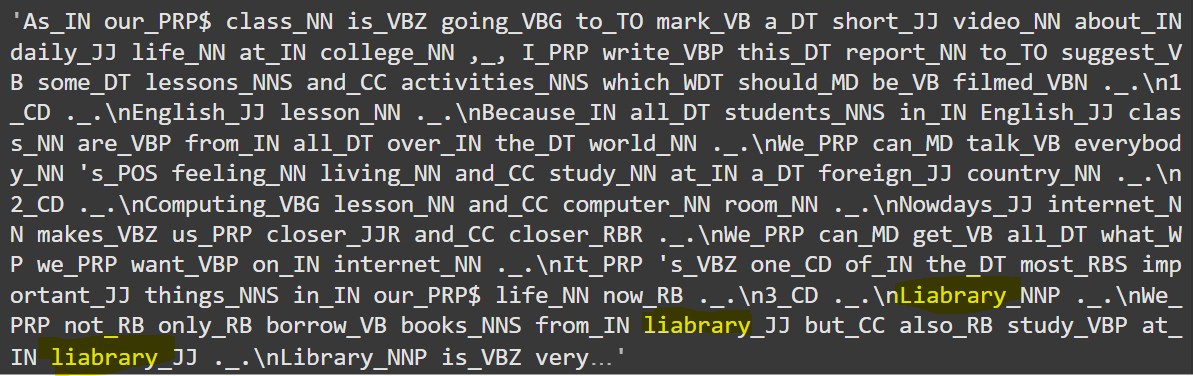

Now let's apply this to the FCE dataset and see what results we'll get from logistic regression then, first just with bag of words:

In [37]:
# Vectorize training data

def vectorize_lr(X_train_tagged, X_test_tagged, y_train_lr, y_test_lr):
    vectorizer_pos = CountVectorizer(stop_words = "english")

    X_train_lr_pos = vectorizer_pos.fit_transform(X_train_tagged)
    X_test_lr_pos = vectorizer_pos.transform(X_test_tagged)

    # Fit model
    weighted_lr_model_pos = LogisticRegression(random_state = 3, solver='liblinear', class_weight = "balanced")
    weighted_lr_model_pos.fit(X_train_lr_pos, y_train_lr)

    y_hat_lr_weighted_pos = weighted_lr_model_pos.predict(X_test_lr_pos)

    # Classification report on testing data
    print("classification report (testing, weighted):\n",
        classification_report(y_test_lr, y_hat_lr_weighted_pos))

    return vectorizer_pos, X_train_lr_pos, X_test_lr_pos, weighted_lr_model_pos, weighted_lr_model_pos, y_hat_lr_weighted_pos

The accuracy has improved a little!

Number of Students in Train: 52, Test: 7, Validation: 7
Training Size: 758, Test Size: 110, Validation Size: 111
                                              answer
1  To: The teacher of English class\nFrom: Jolin\...
2  Fashion is one of the most popular topics peop...
3  One day, a little girls called Sara. She was w...
4  Modern technology has changed my daily life in...
5  Unfortunately, Pat wasn't very good at keeping...
1    True
2    True
3    True
4    True
5    True
Name: Chinese, dtype: bool
Length of training dataset: 758
Length of testing dataset: 110
Length of validation dataset: 111
Length of training dataloader: 95
Length of testing dataloader: 14
Length of validation dataloader: 14
(758, 1)


Epoch 1/1, Loss: 0.096, Val Loss: 0.098, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       110

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


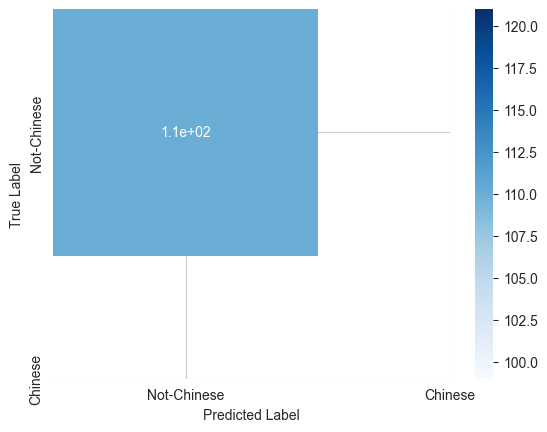

---- REDDIT ----


750it [00:19, 38.38it/s]


Accuracy on Reddit L2 sample: 0.176
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.90      0.93      0.91       108
        True       0.38      0.31      0.34        16

    accuracy                           0.85       124
   macro avg       0.64      0.62      0.63       124
weighted avg       0.83      0.85      0.84       124



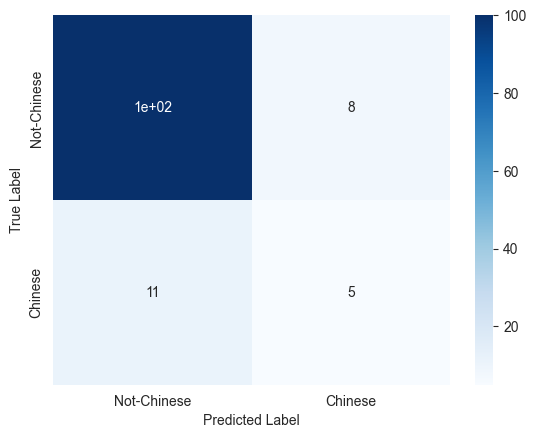

Number of Students in Train: 116, Test: 14, Validation: 15
Training Size: 522, Test Size: 73, Validation Size: 66
                                              answer
0  Dear Madam,\nI am very happy to have won first...
1  Terror in the Alps\nIt was dangerous, but I kn...
2  Dear Mrs Ryan,\nI have just received your lett...
3  Unfortunately, Pat wasn't very good at keeping...
4  There is no need to be a genious to notice tha...
0    True
1    True
2    True
3    True
4    True
Name: French, dtype: bool
Length of training dataset: 522
Length of testing dataset: 73
Length of validation dataset: 66
Length of training dataloader: 66
Length of testing dataloader: 10
Length of validation dataloader: 9
(522, 1)


Epoch 1/1, Loss: 0.138, Val Loss: 0.133, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        73

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


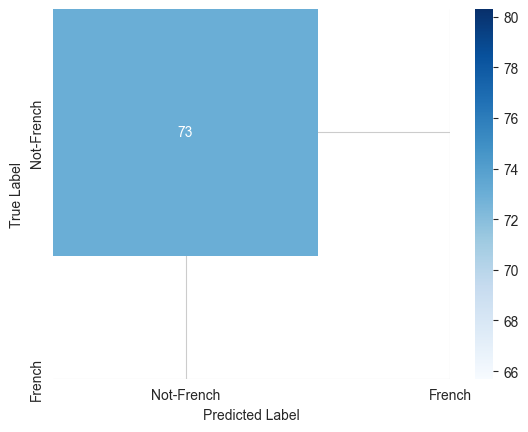

---- REDDIT ----


750it [00:18, 40.19it/s]


Accuracy on Reddit L2 sample: 0.176
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.88      0.88      0.88        98
        True       0.54      0.54      0.54        26

    accuracy                           0.81       124
   macro avg       0.71      0.71      0.71       124
weighted avg       0.81      0.81      0.81       124



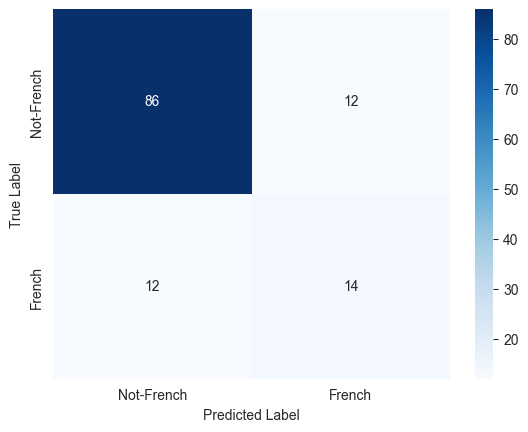

Number of Students in Train: 55, Test: 7, Validation: 7
Training Size: 763, Test Size: 101, Validation Size: 103
                                              answer
0  At first I would say that our technology level...
1  Dear Ms Ryan\nI am very astonished that I won ...
2  17 May 2000\nDear Sir or Mam,\nLast weak, I we...
3  Dear Sirs!\nFirst I want to thank you for all ...
4  Matthias Hähnel\n104 Mühlenstrasse\n09111 Chem...
0    True
1    True
2    True
3    True
4    True
Name: German, dtype: bool
Length of training dataset: 763
Length of testing dataset: 101
Length of validation dataset: 103
Length of training dataloader: 96
Length of testing dataloader: 13
Length of validation dataloader: 13
(763, 1)


Epoch 1/1, Loss: 0.052, Val Loss: 0.064, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       101

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


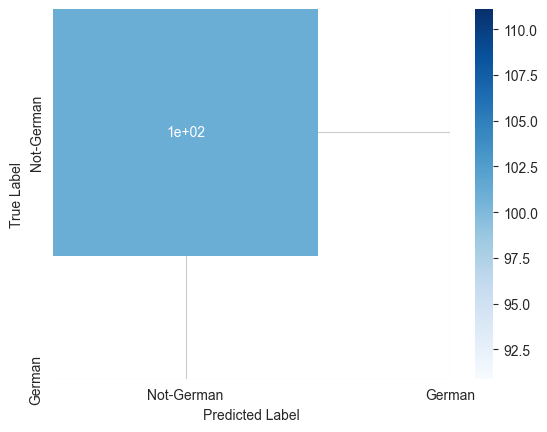

---- REDDIT ----


750it [02:14,  5.59it/s]


Accuracy on Reddit L2 sample: 0.177
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.95      0.92      0.93       116
        True       0.18      0.25      0.21         8

    accuracy                           0.88       124
   macro avg       0.56      0.59      0.57       124
weighted avg       0.90      0.88      0.89       124



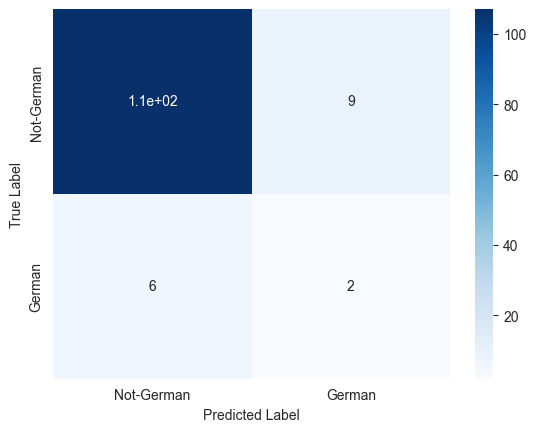

Number of Students in Train: 59, Test: 7, Validation: 8
Training Size: 762, Test Size: 90, Validation Size: 95
                                              answer
0  As we can understand by observing the fashion ...
1  Dear Sir or Madam,\nThank you for your letter....
2  My fair Mobile Phone.\nThe technological revol...
4  Dear Mrs Brown,\nIt would be a pleasure to us ...
5  Shopping is not always enjoyable\nWe people ar...
0    True
1    True
2    True
4    True
5    True
Name: Greek, dtype: bool
Length of training dataset: 762
Length of testing dataset: 90
Length of validation dataset: 95
Length of training dataloader: 96
Length of testing dataloader: 12
Length of validation dataloader: 12
(762, 1)


Epoch 1/1, Loss: 0.088, Val Loss: 0.116, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        90

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


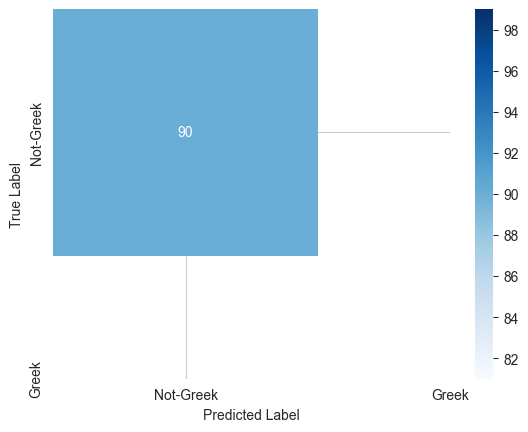

---- REDDIT ----


750it [00:18, 41.39it/s]


Accuracy on Reddit L2 sample: 0.176
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.89      0.96      0.93       104
        True       0.67      0.40      0.50        20

    accuracy                           0.87       124
   macro avg       0.78      0.68      0.71       124
weighted avg       0.86      0.87      0.86       124



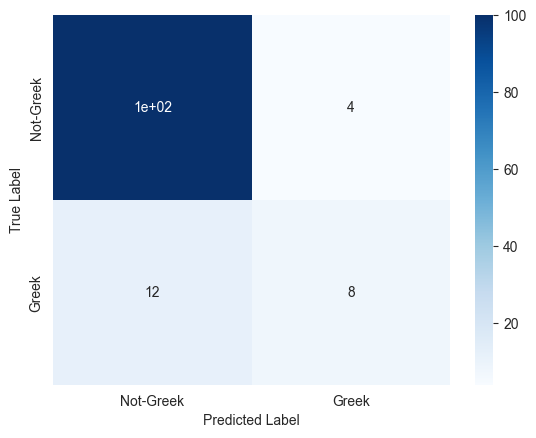

Number of Students in Train: 54, Test: 7, Validation: 7
Training Size: 770, Test Size: 103, Validation Size: 98
                                              answer
0  School days\n, every body have to spend all th...
2  School days\n, every body have to spend all th...
3  \nCars, boats, motobikes, airplanes: Who did n...
4  Madam,\nI am sending you this reply with the i...
5  Sir Manager,\nMy name is Sandre Atos, I am wri...
0    True
2    True
3    True
4    True
5    True
Name: Portuguese, dtype: bool
Length of training dataset: 770
Length of testing dataset: 103
Length of validation dataset: 98
Length of training dataloader: 97
Length of testing dataloader: 13
Length of validation dataloader: 13
(770, 1)


Epoch 1/1, Loss: 0.102, Val Loss: 0.086, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       103

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


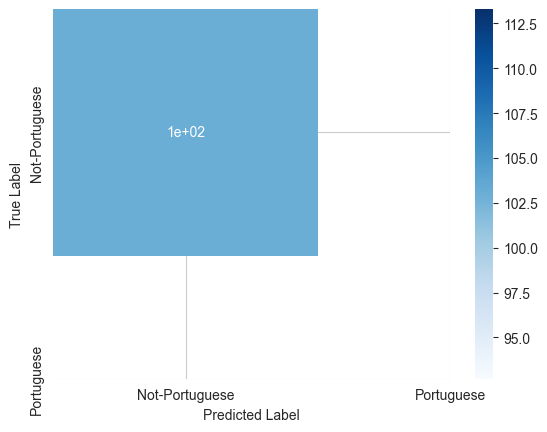

---- REDDIT ----


750it [00:21, 35.10it/s]


Accuracy on Reddit L2 sample: 0.176
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.85      0.96      0.90       104
        True       0.33      0.10      0.15        20

    accuracy                           0.82       124
   macro avg       0.59      0.53      0.53       124
weighted avg       0.76      0.82      0.78       124



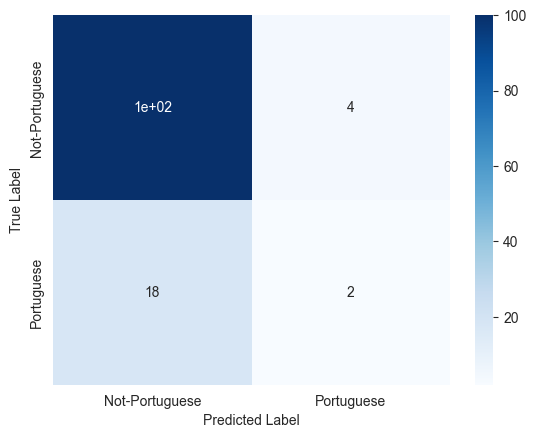

Number of Students in Train: 139, Test: 17, Validation: 18
Training Size: 341, Test Size: 44, Validation Size: 62
                                              answer
0  Hampton Court Palace\nIntroduction:\nI have be...
2  Pat's story\nUnfortunately, Pat wasn't very go...
3  13/JUNE/2000\nDEAR HELEN RYAN,\nFIRST OF ALL I...
4  Unfortunately, Pat wasn't very good at keeping...
5  Shopping is not always enjoyable. You have to ...
0    True
2    True
3    True
4    True
5    True
Name: Spanish, dtype: bool
Length of training dataset: 341
Length of testing dataset: 44
Length of validation dataset: 62
Length of training dataloader: 43
Length of testing dataloader: 6
Length of validation dataloader: 8
(341, 1)


Epoch 1/1, Loss: 0.112, Val Loss: 0.103, Val Accuracy: 1.000
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        44

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



/Users/anjieliu/Library/Mobile Documents/com~apple~CloudDocs/Documents/MyUT/Year3/Fall2024/LIN 371 Machine Learning for Text Analysis/LIN371_Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


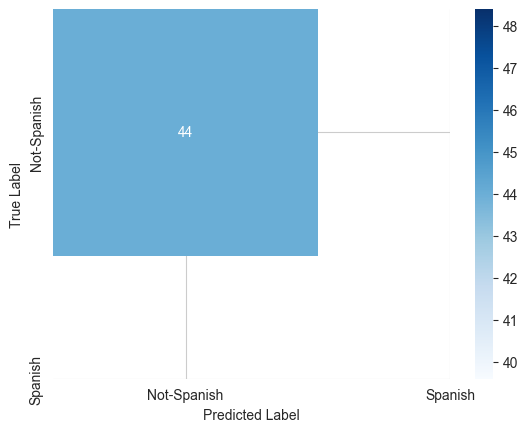

---- REDDIT ----


750it [00:19, 38.74it/s]


Accuracy on Reddit L2 sample: 0.176
----------------
Number of Students in Train: 498, Test: 62, Validation: 63
Training Size: 993, Test Size: 124, Validation Size: 126
classification report (testing, weighted):
               precision    recall  f1-score   support

       False       0.84      0.73      0.78        90
        True       0.47      0.62      0.53        34

    accuracy                           0.70       124
   macro avg       0.65      0.68      0.66       124
weighted avg       0.73      0.70      0.71       124



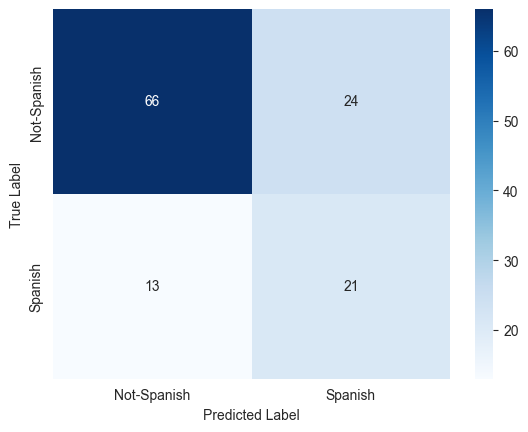

In [38]:
#### RUN THIS TO USE MODEL

for num in range(len(decode_l1)):
    lang_list = get_lang(num)

    ## cambridge nn

    lang_counts = get_lang_counts(num, data)
    oversample_data = oversample(lang_counts=lang_counts, data = data)
    check_oversample(oversample_data, data)
    random_simulate_macrof1(lang_counts)

    # Create our training, testing, and validation sets
    X_train, X_test, X_valid, y_train, y_test, y_valid = get_splits(num, oversample_data)

    print(X_train.head())
    print(y_train.head())

    train_dataset, test_dataset, valid_dataset = train_model(X_train, X_test, X_valid, y_train, y_test, y_valid)

    print("Length of training dataset:", len(train_dataset))
    print("Length of testing dataset:", len(test_dataset))
    print("Length of validation dataset:", len(valid_dataset))

    train_loader = dataset_to_loader(train_dataset)
    test_loader = dataset_to_loader(test_dataset)
    valid_loader = dataset_to_loader(valid_dataset)

    print("Length of training dataloader:", len(train_loader))
    print("Length of testing dataloader:", len(test_loader))
    print("Length of validation dataloader:", len(valid_loader))

    print(X_train.shape)

    # Create our neural network as an instance of the feedforward_nn_bert class
    model = feedforward_nn_bert()

    criterion, optimizer, scheduler, epochs = get_loss_info()

    train_nn(model,
        train_loader, test_loader, valid_loader, use_cuda,
        epochs = epochs, learning_rate = 2e-2, batch_size = batch_size)

    # Evaluate and make confusion matrix
    test_loss, test_accuracy, test_labels, test_preds, report = eval_nn(model, test_loader)
    print(report)
    create_cm(test_labels, test_preds)


    ## reddit nn
    print("---- REDDIT ----")
    eval_reddit()
    print("----------------")


    ## logistic regression
    X_train_lr, X_test_lr, X_val_lr, y_train_lr, y_test_lr, y_val_lr = get_lr_split(num)

    X_train_tagged = X_train_lr["answer"].apply(append_pos_tags)
    X_test_tagged = X_test_lr["answer"].apply(append_pos_tags)

    #vectorizer = CountVectorizer(stop_words = "english")
    #X_train_lr = vectorizer.fit_transform(X_train_tagged)
    #X_test_lr = vectorizer.transform(X_test_tagged)

    vectorizer_pos, X_train_lr_pos, X_test_lr_pos, weighted_lr_model_pos, weighted_lr_model_pos, y_hat_lr_weighted_pos = vectorize_lr(X_train_tagged, X_test_tagged, y_train_lr, y_test_lr)

    # Visualize confusion matrix for weighted logistic regression + POS tags
    create_cm(y_test_lr, y_hat_lr_weighted_pos)
